In [3]:
import IPython.display as ipd
import numpy as np
import autograd
import torch
from kymatio import Scattering1D

from torch.autograd import backward
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

## Regress a synthetic signal from its scattering transform

In this example we generate a harmonic signal of a few different frequencies, analyze it with the 1D scattering transform, and regress the scattering transform back to the harmonic signal.

In [1]:
def generate_harmonic_signal(T, num_intervals=4, gamma=0.9, random_state=42):
    """
    Generates a harmonic signal, which is made of piecewise constant notes
    (of random fundamental frequency), with half overlap
    """
    rng = np.random.RandomState(random_state)
    num_notes = 2 * (num_intervals - 1) + 1
    support = T // num_intervals
    half_support = support // 2

    base_freq = 0.1 * rng.rand(num_notes) + 0.05
    phase = 2 * np.pi * rng.rand(num_notes)
    window = np.hanning(support)
    x = np.zeros(T, dtype='float32')
    t = np.arange(0, support)
    u = 2 * np.pi * t
    for i in range(num_notes):
        ind_start = i * half_support
        note = np.zeros(support)
        for k in range(1):
            note += (np.power(gamma, k) *
                     np.cos(u * (k + 1) * base_freq[i] + phase[i]))
        x[ind_start:ind_start + support] += note * window
    # Transform x into a torch Tensor
    x = torch.from_numpy(x[np.newaxis])
    return x

## Let’s take a look at what such a signal could look like

Text(0.5, 1.0, 'Original signal')

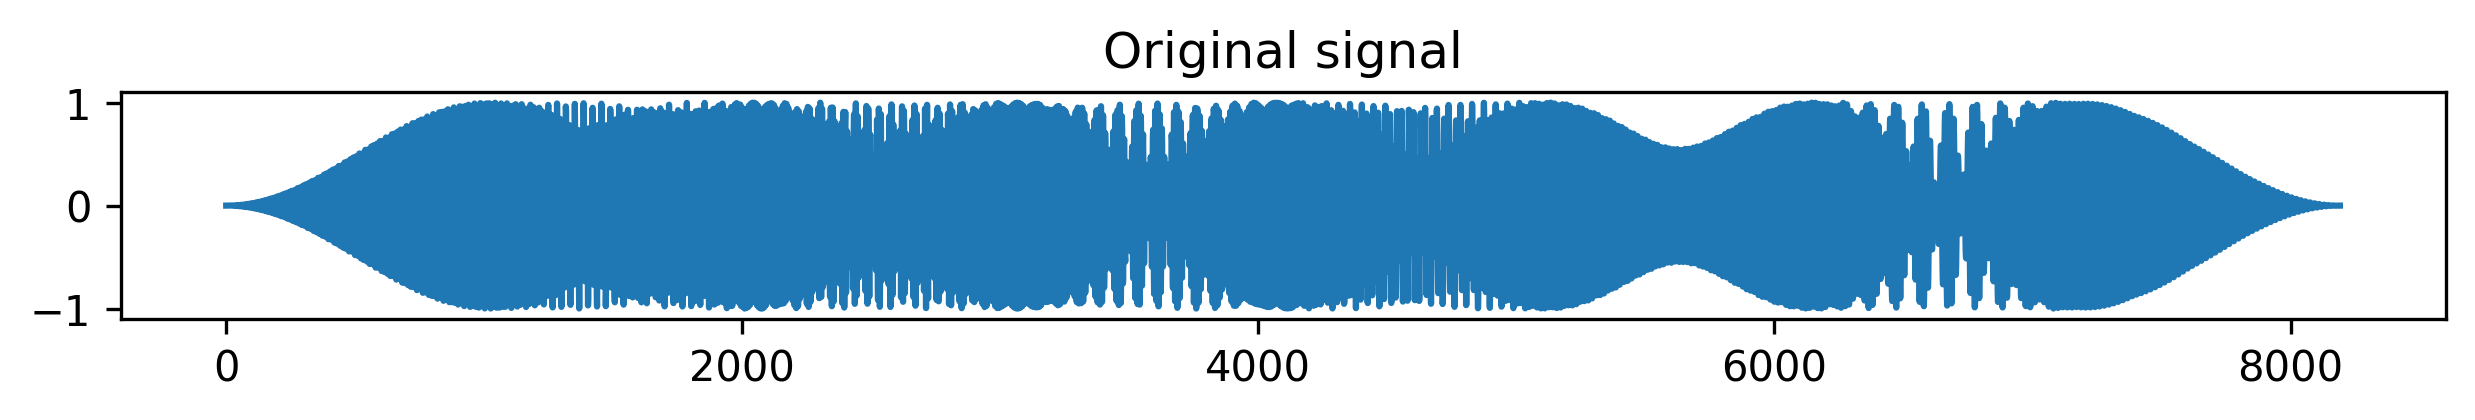

In [4]:
T = 2 ** 13
x = generate_harmonic_signal(T)
plt.figure(figsize=(10, 1), dpi=300)
plt.plot(x.numpy().ravel())
plt.title("Original signal")

## Spectrogram
Let’s take a look at the signal spectrogram

Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

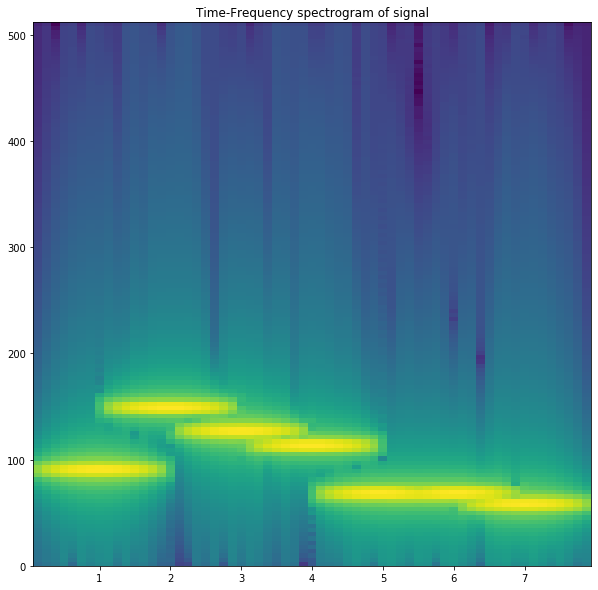

In [6]:
plt.figure(figsize=(10, 10))
plt.specgram(x.numpy().ravel(), Fs=1024)
plt.title("Time-Frequency spectrogram of signal")

## Doing the scattering transform

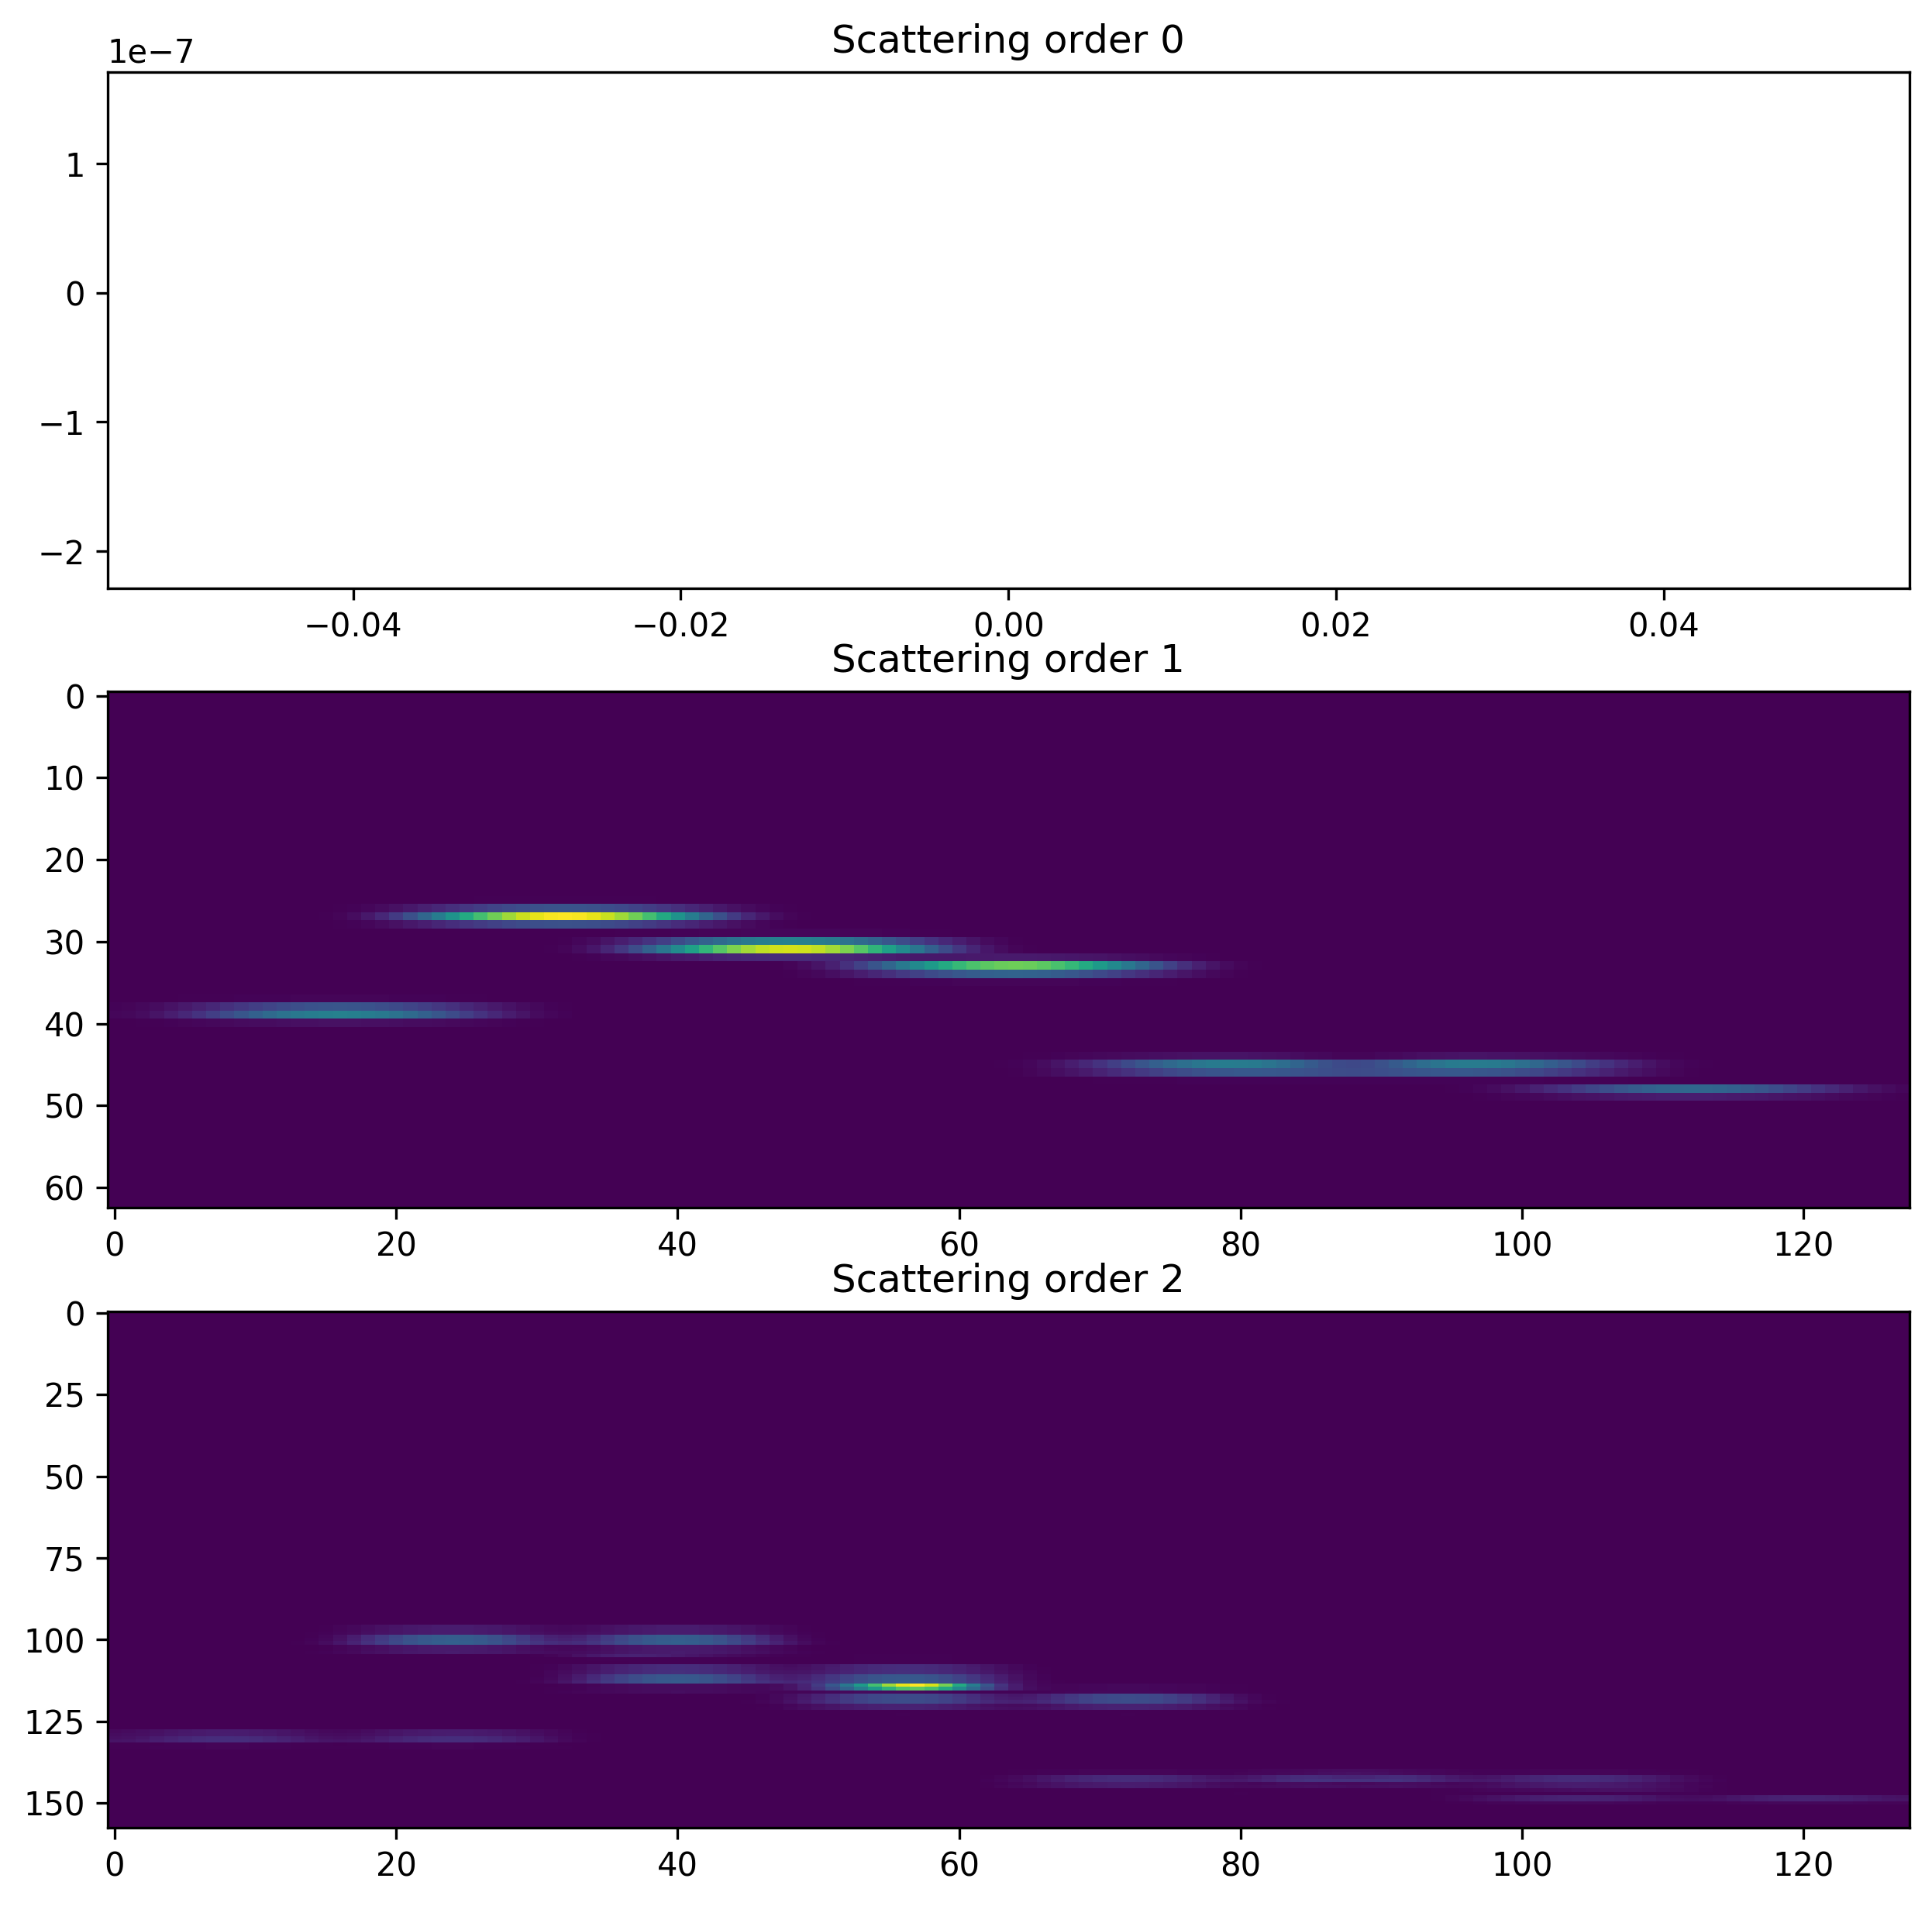

In [7]:
J = 6
Q = 16

scattering = Scattering1D(J, T, Q)

# get the metadata on the coordinates of the scattering
meta = Scattering1D.compute_meta_scattering(J, Q)
order0 = (meta['order'] == 0)
order1 = (meta['order'] == 1)
order2 = (meta['order'] == 2)

s = scattering.forward(x)[0]
plt.figure(figsize=(10, 10), dpi=300)
plt.subplot(3, 1, 1)
plt.plot(s[order0].numpy())
plt.title("Scattering order 0")
plt.subplot(3, 1, 2)
plt.imshow(s[order1].numpy(), aspect='auto')
plt.title("Scattering order 1")
plt.subplot(3, 1, 3)
plt.imshow(s[order2].numpy(), aspect='auto')
plt.title("Scattering order 2")

plt.show()

In [9]:
s.shape

torch.Size([222, 128])

## Regress the scattering transform back to original signal

In [45]:
def normalize(S):
    S_relu = 1e-6 + torch.nn.functional.relu(S)
    return S_relu / torch.norm(S_relu)

def regress_signal(
        s_c, N, J,
        learning_rate=0.1,
        momentum=0.0,
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.5,
        n_iterations=100,
        cost = "mse",
        verbose=False):
    """
    this function finds time-domain signal from scattering transform
    input: scattering tranform tensor, length of the signal, learning rate and number of iterations
    output: time-domain signal represented in a tensor
    """
    
    scattering = Scattering1D(J, N, Q)

    #random guess
    x = torch.randn((N,),requires_grad=True)
    Sx = scattering(x)
    #target to regress
    Sy = s_c
    history = []
    signal_update = 0*x 

    #normalize Sy for K-L divergence
    Sy_normalized = normalize(Sy) #Sy is the target
    
    #iterate to regress random guess to be close to target
    for it_id in tqdm_notebook(range(n_iterations), disable=not verbose):
        
        # Backpropagation
        if cost == "mse":
            err = torch.norm(Sx-Sy)
        elif cost == "cross-entropy":        
            Sx_normalized = normalize(Sx)
            err = torch.sum(Sx_normalized * torch.log((Sx_normalized / Sy_normalized)))      
        backward(err)

        delta_x = x.grad 
        
        # Gradient descent
        with torch.no_grad():
            momentum = min(0.99,1-2**(-1-np.log(np.floor(it_id/250)+1)/np.log(2))) #according to Sutskever et al., adaptive momentum
            signal_update = momentum * signal_update - delta_x * learning_rate
            new_x = x + signal_update
        new_x.requires_grad = True

        # New forward propagation
        Sx = scattering(new_x)
        # Measure the new loss
        history.append(err)
        
        if history[it_id]> history[it_id-1]:
            learning_rate *= bold_driver_brake
        else:
            learning_rate *= bold_driver_accelerator
            x = new_x
     
    return x,history

## Using mean square error as cost function

A Jupyter Widget

lr = 100.000     loss= 0.471


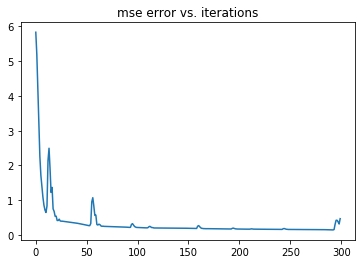

In [49]:
x_interpolated,history = regress_signal(
    s, T, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.55,
    momentum=0.6, 
    n_iterations=300, 
    cost = "mse", 
    verbose=True)
plt.plot(history)
plt.title("mse error vs. iterations")
print("lr = {:6.3f}     loss={:6.3f}".format(100, history[-1]))

Text(0.5, 1.0, 'Interpolated signal')

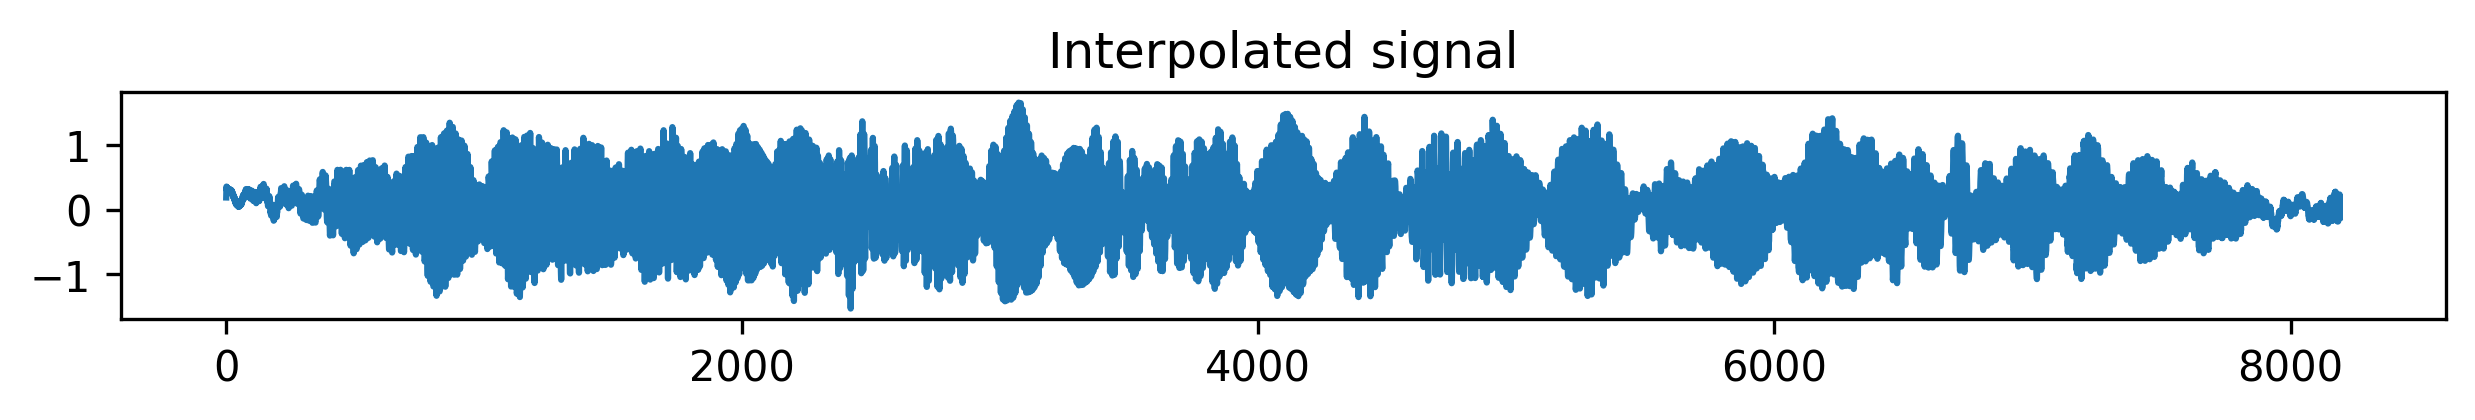

In [50]:
plt.figure(figsize=(10, 1), dpi=300)
plt.plot(x_interpolated.detach().numpy().ravel())
plt.title("Interpolated signal")

Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

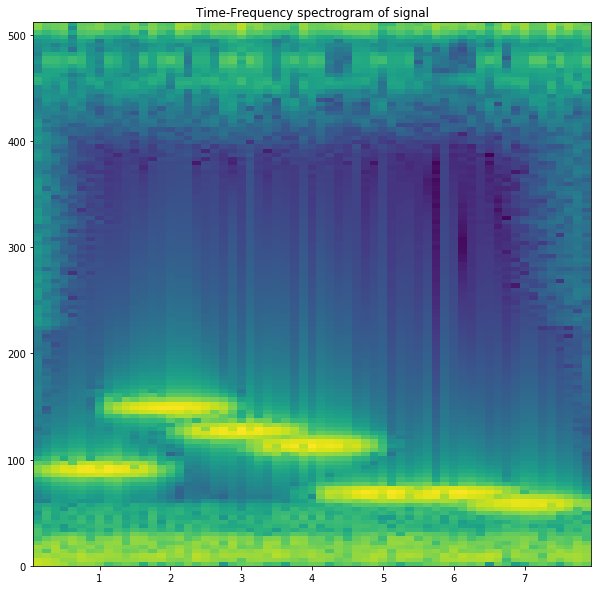

In [51]:
plt.figure(figsize=(10, 10))
plt.specgram(x_interpolated.detach().numpy().ravel(), Fs=1024)
plt.title("Time-Frequency spectrogram of signal")

## Using Kullback–Leibler divergence as cost function

A Jupyter Widget


lr = 100.000     loss=45.977


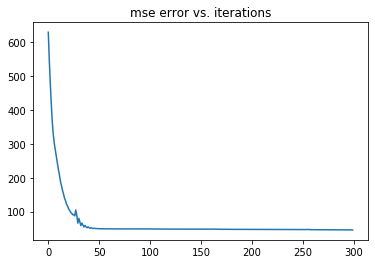

In [32]:
x_interpolated,history = regress_signal(
    s, T, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.55,
    momentum=0.6, 
    n_iterations=300, 
    cost = "cross-entropy", 
    verbose=True)
plt.plot(history)
plt.title("K-L divergence error vs. iterations")
print("lr = {:6.3f}     loss={:6.3f}".format(100, history[-1]))

Text(0.5, 1.0, 'Interpolated signal')

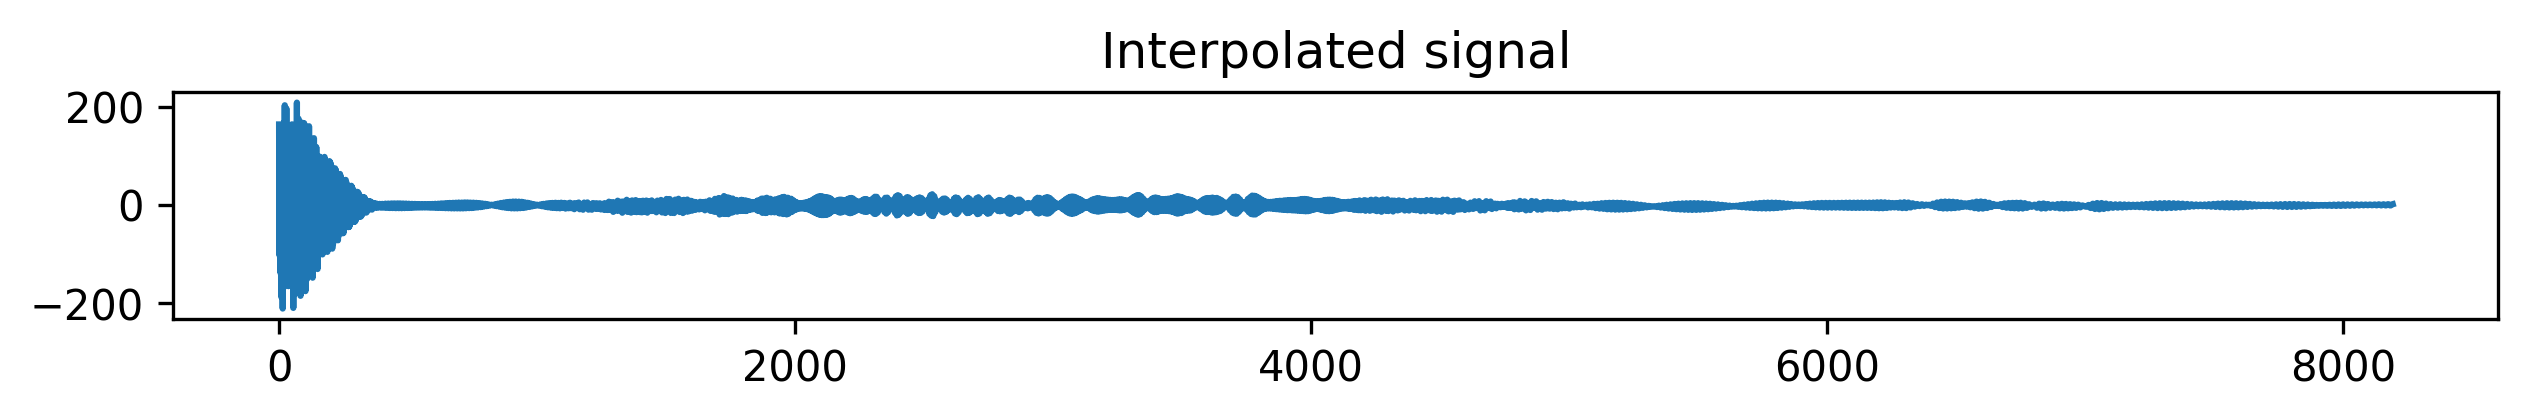

In [37]:
plt.figure(figsize=(10, 1), dpi=300)
plt.plot(x_interpolated.detach().numpy().ravel())
plt.title("Interpolated signal")

Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

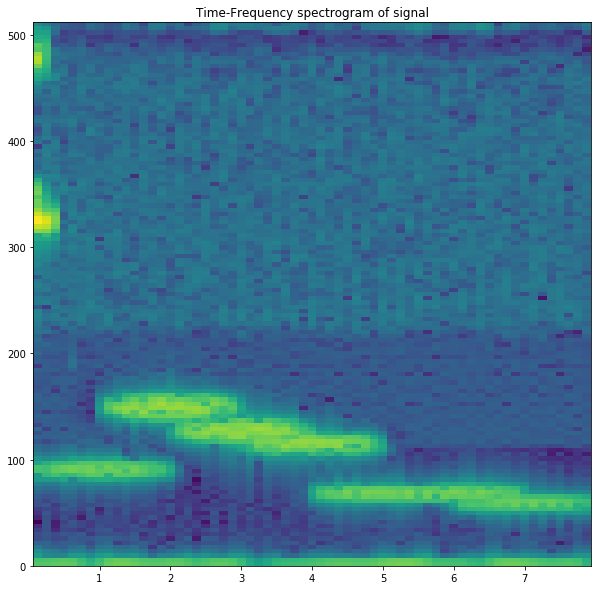

In [34]:
plt.figure(figsize=(10, 10))
plt.specgram(x_interpolated.detach().numpy().ravel(), Fs=1024)
plt.title("Time-Frequency spectrogram of signal")